Load image

In [1]:
from huggingface_hub import login

login("")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /Users/andrejb/.cache/huggingface/token
Login successful


In [3]:
from datasets import load_dataset

dataset = load_dataset("katanaml-org/invoices-donut-data-v1")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/425 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/andrejb/.cache/huggingface/datasets/katanaml-org___parquet/katanaml-org--invoices-donut-data-v1-53504892a78fb48e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

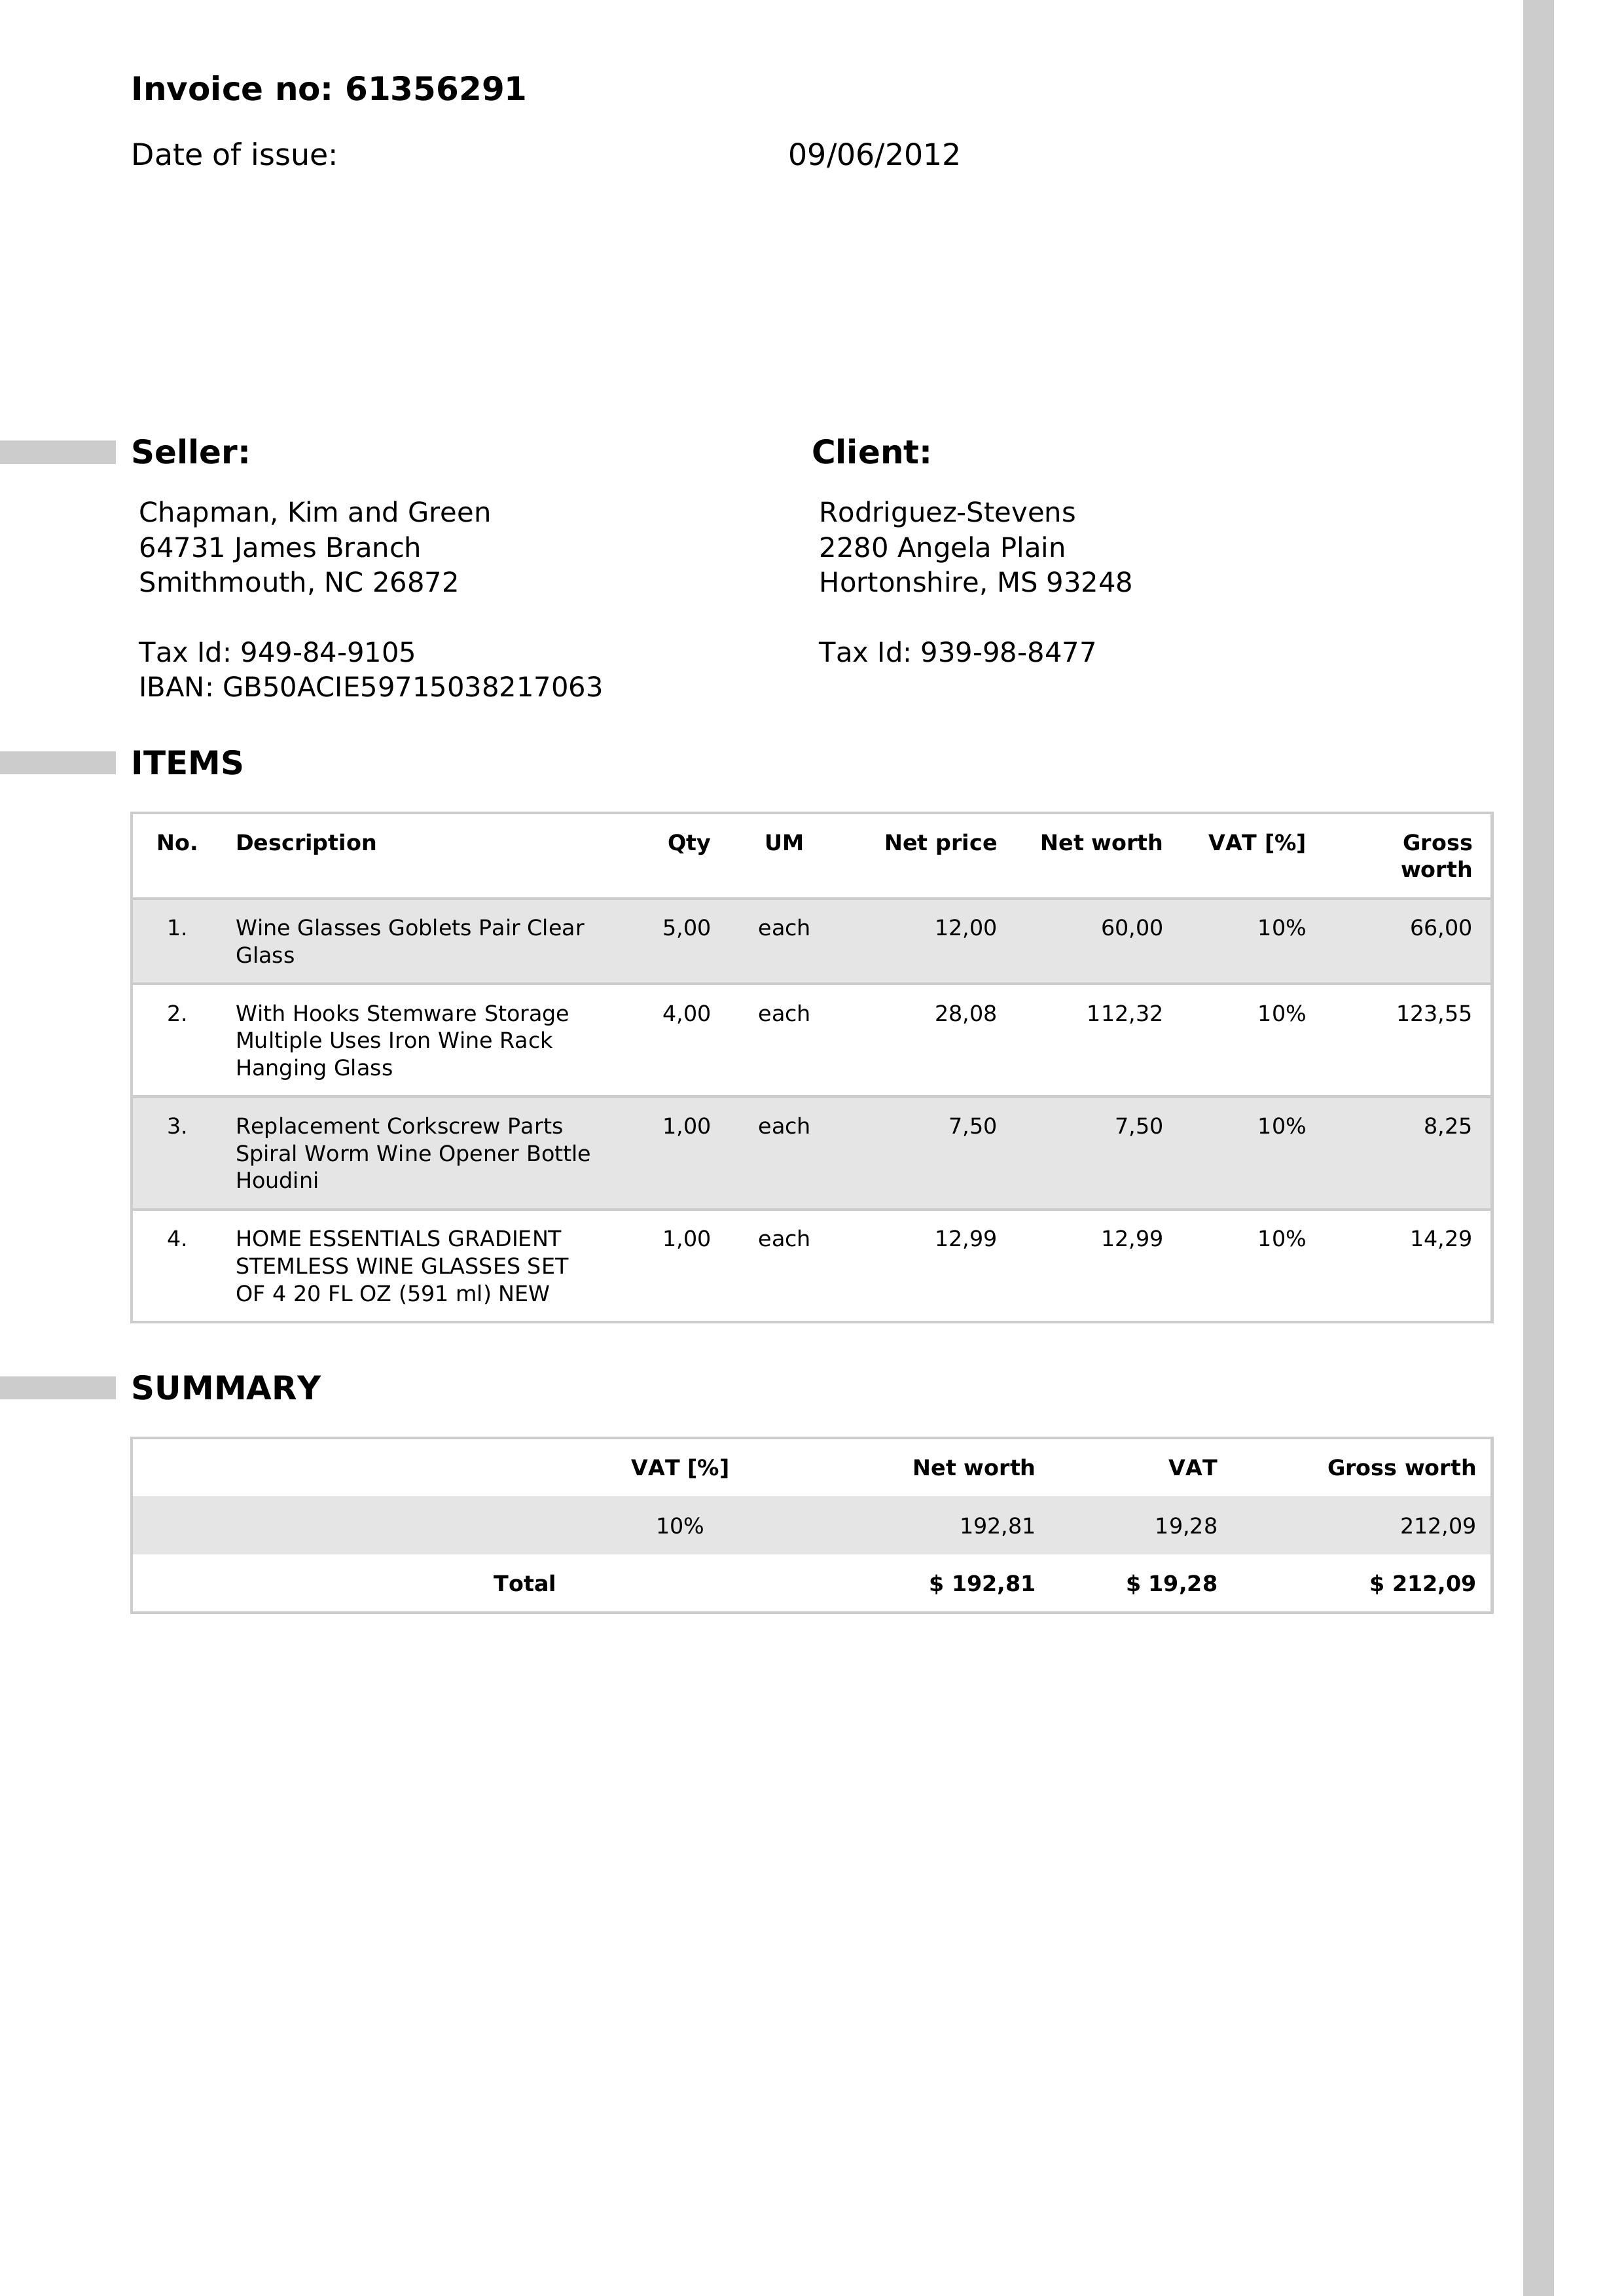

In [19]:
image = dataset['test'][10]['image']
image

Load model and processor

In [5]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("katanaml-org/invoices-donut-model-v1")
model = VisionEncoderDecoderModel.from_pretrained("katanaml-org/invoices-donut-model-v1")

Prepare using processor
We prepare the image for the model using DonutProcessor.

In [20]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


Generate
Finally, we let the model autoregressively generate the structured data.

In [21]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

In [22]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_header><s_invoice_no> 61356291</s_invoice_no><s_invoice_date> 09/06/2012</s_invoice_date><s_seller> Chapman, Kim and Green 64731 James Branch Smithmouth, NC 26872</s_seller><s_client> Rodriguez-Stevens 2280 Angela Plain Hortonshire, MS 93248</s_client><s_seller_tax_id> 949-84-9105</s_seller_tax_id><s_client_tax_id> 939-98-8477</s_client_tax_id><s_iban> GB50ACIE59715038217063</s_iban></s_header><s_items><s_item_desc> Wine Glasses Goblets Pair Clear Glass</s_item_desc><s_item_qty> 5,00</s_item_qty><s_item_net_price> 12,00</s_item_net_price><s_item_net_worth> 60,00</s_item_net_worth><s_item_vat> 10%</s_item_vat><s_item_gross_worth> 66,00</s_item_gross_worth><sep/><s_item_desc> With Hooks Stemware Storage Multiple Uses Iron Wine Rack Hanging Glass</s_item_desc><s_item_qty> 4,00</s_item_qty><s_item_net_price> 28,08</s_item_net_price><s_total_net_worth> 112,32</s_total_net_worth><s_item_vat> 10%</s_item_vat><s_item_gross_worth> 123,55</s_item_gross_worth><sep/><s_item_desc> Replacement Co

Convert to JSON
We can convert the generated sequence to JSON if required:

In [23]:
processor.token2json(sequence)

{'header': {'invoice_no': '61356291',
  'invoice_date': '09/06/2012',
  'seller': 'Chapman, Kim and Green 64731 James Branch Smithmouth, NC 26872',
  'client': 'Rodriguez-Stevens 2280 Angela Plain Hortonshire, MS 93248',
  'seller_tax_id': '949-84-9105',
  'client_tax_id': '939-98-8477',
  'iban': 'GB50ACIE59715038217063'},
 'items': [{'item_desc': 'Wine Glasses Goblets Pair Clear Glass',
   'item_qty': '5,00',
   'item_net_price': '12,00',
   'item_net_worth': '60,00',
   'item_vat': '10%',
   'item_gross_worth': '66,00'},
  {'item_desc': 'With Hooks Stemware Storage Multiple Uses Iron Wine Rack Hanging Glass',
   'item_qty': '4,00',
   'item_net_price': '28,08',
   'total_net_worth': '112,32',
   'item_vat': '10%',
   'item_gross_worth': '123,55'},
  {'item_desc': 'Replacement Corkscrew Parts Spiral Worm Wine Opener Bottle Houdini',
   'item_qty': '1,00',
   'item_net_price': '7,50',
   'total_net_worth': '7,50',
   'item_vat': '10%',
   'item_gross_worth': '8,25'},
  {'item_desc': '